In [1]:
import sys
sys.path.append(R'C:\Users\pjh7\git\k-wave-python')
import pyfus
from typing import List, Dict, Any, Tuple
import logging
import matplotlib.pyplot as plt
import xarray as xa
root = logging.getLogger()
loglevel = logging.INFO
root.setLevel(loglevel)
handler = logging.StreamHandler(sys.stdout)
handler.setLevel(loglevel)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
root.addHandler(handler)
import numpy as np


In [13]:

db = pyfus.database.Database(path=R'C:/Users/pjh7/Documents/dom/')
arr = db.load_transducer('vermon')
trans_matrix = np.array(
    [[-1,   0,  0, 0],
     [0, .05,  np.sqrt(1-.05**2), -105],
     [0, np.sqrt(1-.05**2),  -.05, 5],
     [0, 0,  0, 1]])
arr.rescale("mm")
arr.matrix = trans_matrix
pt = pyfus.geo.Point(position=(5,-60,-8), units="mm", radius=2)
#pt = pyfus.geo.Point(position=(0,0,50), units="mm", radius=2)
#pt.transform(trans_matrix)
plan = db.load_plan('example_plan')
plan.sim_grid.dt = 2e-7
plan.sim_grid.t_end = 100e-6
pulse = plan.pulse
pts = plan.focal_pattern.get_targets(pt)
coords = plan.sim_grid.get_coords()
params = plan.bf_plan.get_ref_params(coords)
delays, apod = plan.bf_plan.beamform(arr=arr, target=pts[0], params=params)


2023-11-09 10:39:14,946 - root - INFO - Initializing transducer array
2023-11-09 10:39:14,948 - pyfus.database - INFO - Loaded plan example_plan


In [8]:
arr.units

'm'

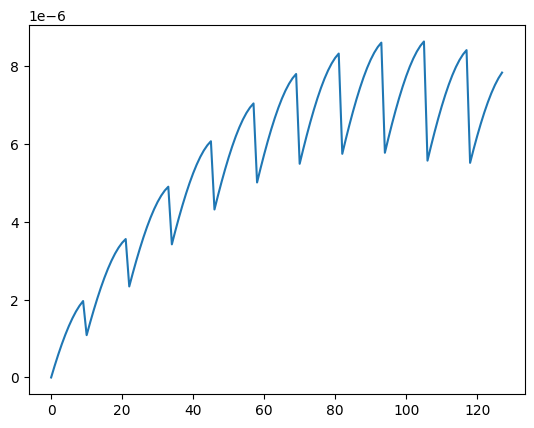

In [14]:
plt.plot(delays)

In [11]:
ds, output = pyfus.sim.run_simulation(arr=arr, 
               params=params, 
               delays=delays,
               apod= apod,
               freq = pulse.frequency,
               cycles = np.max([np.round(pulse.duration * pulse.frequency), 20]),
               dt=plan.sim_grid.dt,
               t_end=plan.sim_grid.t_end,
               bli_tolerance=0.2,
               upsampling_rate=4,
               amplitude = 1,
               db = db,
               save_gridweights=False)

2023-11-09 10:34:59,513 - root - INFO - Calculating grid weights


2023-11-09 10:35:02,969 - root - INFO - Getting binary mask
2023-11-09 10:35:03,659 - root - INFO - Getting distributed source signal
2023-11-09 10:35:04,345 - root - INFO - approximate size of source matrix: 12.17 G B ( float32 precision)
2023-11-09 10:35:04,523 - root - INFO - total computation time : 0.86 s
2023-11-09 10:35:04,524 - root - INFO - Running simulation
2023-11-09 10:35:04,525 - root - INFO - Starting Simulation Setup
2023-11-09 10:35:04,525 - root - INFO -   start time: 09-Nov-2023-10-35-04
2023-11-09 10:35:04,526 - root - INFO - Running k-Wave simulation...
2023-11-09 10:35:04,526 - root - INFO -   start time: 09-Nov-2023-10-35-04
2023-11-09 10:35:04,527 - root - INFO -   reference sound speed: 1500.0 m/s
2023-11-09 10:35:04,527 - root - INFO -   reference sound speed: 1500.0 m/s
2023-11-09 10:35:04,537 - root - INFO -   dt: 200ns, t_end: 99.8us, time steps: 500
2023-11-09 10:35:04,537 - root - INFO -   input grid size: 61 by 61 by 75 grid points (61.0 by 61.0 by 75.0 

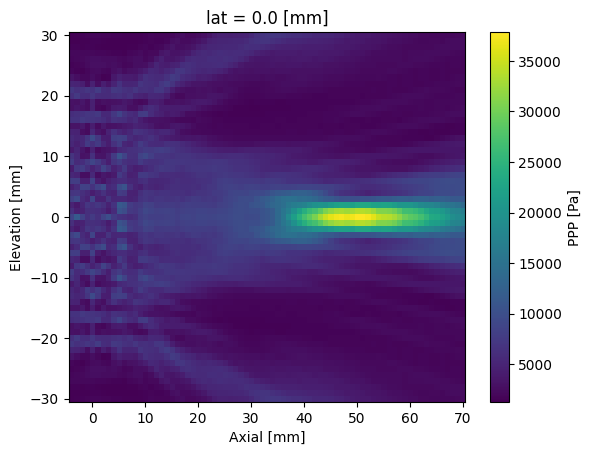

In [12]:
ds['p_max'].sel(lat=0).plot.imshow()

In [ ]:
import pandas as pd
import nibabel as nb
trans_matrix = np.array(
    [[-1,   0,  0, 0],
     [0, .05,  np.sqrt(1-.05**2), -105],
     [0, np.sqrt(1-.05**2),  -.05, 5],
     [0, 0,  0, 1]])
origin_local = [float(val[0]) for dim, val in ds['p_max'].coords.items()]
print(pd.DataFrame(trans_matrix))
affine = np.concatenate([trans_matrix[:,:3], trans_matrix @ np.array(origin_local + [1]).reshape([4,1])], axis=1)
print(pd.DataFrame(affine))
data = ds['p_max'].data
im = nb.Nifti1Image(data, affine)
im.set_sform(affine, code=3)
im = nb.as_closest_canonical(im)
im.to_filename("foo.nii.gz")


In [ ]:
kgrid = pyfus.sim.get_kgrid(params.coords, dt=2e-7, t_end=100e-6)
pcoords = params.coords['lat'].attrs['units']
scl = pyfus.util.units.getunitconversion(pcoords, 'm')
array_offset =[-float(coord.mean())*scl for coord in params.coords.values()]
karray = pyfus.sim.get_karray(arr, bli_tolerance=0.05, upsampling_rate=5)

In [ ]:

grid_weights = np.array([karray.get_element_grid_weights(kgrid, i) for i in range(karray.number_elements)])

In [ ]:
from kwave.utils.mapgen import trim_cart_points, make_cart_rect, make_cart_arc, make_cart_bowl, make_cart_disc, \
    make_cart_spherical_segment

In [ ]:
arr

In [ ]:
element_num = 0
m_grid = karray.elements[element_num].measure / (kgrid.dx) ** (karray.elements[element_num].dim)
m_integration = np.ceil(m_grid * karray.upsampling_rate)
scale = m_grid / m_integration
integration_points = make_cart_rect(
    karray.affine(karray.elements[element_num].position),
    karray.elements[element_num].length,
    karray.elements[element_num].width,
    karray.elements[element_num].orientation,
    m_integration)
integration_points = trim_cart_points(kgrid, integration_points)

In [ ]:
from kwave.utils.kwave_array import off_grid_points    
grid_weights = off_grid_points(kgrid, integration_points, scale,
                                    bli_tolerance=karray.bli_tolerance,
                                    bli_type=karray.bli_type,
                                    mask_only=False,
                                    single_precision=karray.single_precision)

In [ ]:
grid_weights.shape
import nibabel as nb
data = np.array(grid_weights[0])
nb.Nifti1Image(data, np.eye(4)).to_filename("gridweights.nii.gz")

In [ ]:
im = nb.load(R"H:\Shared drives\OpenwaterTeam\Ultrasound\Transcranial\open_pyfus_data\db\downloaded_example_data\average305_t1_tal_lin.nii")
im

In [ ]:
import scipy.io as spio

def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], spio.matlab.mat_struct):
            dict[key] = _todict(dict[key])
        elif isinstance(dict[key], np.ndarray) and len(dict[key])>0 and isinstance(dict[key][0], spio.matlab.mat_struct):
            dict[key] = np.array([_todict(item) for item in dict[key]])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, spio.matlab.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

matfilename = R"C:\Users\pjh7\git\open_tfus\foo.mat"
mat = loadmat(matfilename)


In [ ]:
dx = [np.mean(np.diff(c['data'])) for c in mat['coords']]
sform = mat['matrix']
h = nb.Nifti1Header()
h.set_xyzt_units('mm', 'sec')
sform = sform * np.array(dx + [1])
h.set_qform(sform, code=3)
h.set_sform(sform, code=3)
data = mat['data'].copy(order='C')
h.set_data_dtype(data.dtype)
h.set_data_shape(data.shape)
im = nb.Nifti1Image(data, sform)
im.set_sform(sform, code=3)
im.to_filename("foo.nii.gz")

In [ ]:
np.round(im.affine, 3)

In [ ]:
import nibabel as nb
p_max = ds['ita'].data
coords = ds.coords
affine = np.eye(3) * np.array([float(np.diff(coords[x][:2])) for x in coords])
origin = np.array([float(coords[x][0]) for x in coords]).reshape(3,1)
affine = np.concatenate([np.concatenate([affine, origin], axis=1),np.array([0,0,0,1]).reshape(1,4)], axis=0)
nb.Nifti1Image(p_max, affine).to_filename("intensity.nii.gz")

In [ ]:

focal_pattern = pyfus.bf.RadialPattern(center=True, spoke_radius=5, num_spokes=5)
sim_grid = pyfus.bf.SimulationGrid(dt=2e-7, t_end=100e-6)
pulse = pyfus.bf.Pulse(frequency=400e3, duration=3/400e3)
sequence = pyfus.bf.Sequence()
bfp = pyfus.bf.BeamformingPlan()
plan = pyfus.plan.Plan(pulse=pulse,
                 sequence=sequence,
                 focal_pattern=focal_pattern,
                 sim_grid=sim_grid,
                 bf_plan = bfp)

In [ ]:
import nibabel as nb
p_max = output['p_min'].data
coords = output.coords
affine = np.eye(3) * np.array([float(np.diff(coords[x][:2])) for x in coords])
origin = np.array([float(coords[x][0]) for x in coords]).reshape(3,1)
affine = np.concatenate([np.concatenate([affine, origin], axis=1),np.array([0,0,0,1]).reshape(1,4)], axis=0)
nb.Nifti1Image(p_max, affine).to_filename("p_max.nii.gz")

In [ ]:
import vtk
arr_actor = arr.get_actor(units="mm")
renderWindow = vtk.vtkRenderWindow()
renderer = vtk.vtkRenderer()
renderWindow.AddRenderer(renderer)
renderWindowInteractor = vtk.vtkRenderWindowInteractor()
renderWindowInteractor.SetRenderWindow(renderWindow)
renderer.AddActor(arr_actor)
for pti in pts:
    pt_actor = pti.get_actor()
    renderer.AddActor(pt_actor)
renderWindow.Render()
renderWindowInteractor.Start()